Изоляция рабочего окружения является правилом хорошего тона при программировании на Python. Создание виртуального окружения позволяет быть уверенным в том, что проект будет работать на другом устройстве так же как и на локальной машине.

Создадим вирутальное окружение *venv* и активируем оболочку:

```
virtualenv --python=python3.6 venv
source venv/bin/activate
```

Установим необходимые библиотеки при помощи *pip*, затем запишем их в файл requirements.txt, чтобы пользователь мог легко их установить

```
# to record all packages installed in venv
pip freeze > requirements.txt

# to install all packages listed in requirements.txt
pip install -r requirements.txt
```

Добавим виртуальное окружение в jupyter

```
python -m ipykernel install --user --name=venv
```

**Если возникают ошибки связанные с импортом библиотек, следует убедиться, что используется виртуальное окружение для этого во вкладке kernel --> change kernel выберем venv**


In [1]:
import pandas as pd
from bs4 import BeautifulSoup

Нашим подопытным будет сайт Zillow.

Посмотрим на него внимательно: в адресной строке видим координаты прямоугольной области поиска и её масштабирующий параметр. Таким образом мы заметили, что изменяя параметры ссылки мы можем манипулировать областью поиска. Существует и ещё один параметр, отвечающий за номер страницы в каталоге. Таким образом полный шаблон ссылки будет выглядеть так: 

<span color="blue">https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/{lat1},{lng1},{lat2},{lng2}_rect/{scale}_zm/{page}_p/</span>

<img src="img/site.png" width=70% height=70%>

In [2]:
# Чтобы обращаться за информацией по заданным координатам реализуем шаблон
from string import Template

link_temp = Template('https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/${lat1},${lng1},${lat2},${lng2}_rect/${scale}_zm/${page}_p/')

# Зададим параметры поиска
search_params = {
    "lat1": 37.090239,
    "lng1": -95.023499,
    "lat2": 34.764178,
    "lng2": -98.648987,
    "scale": 10,
    "page": 1
}

link = link_temp.substitute(**search_params)
print(link)

https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/37.090239,-95.023499,34.764178,-98.648987_rect/10_zm/1_p/


Поскольку Selenium является достаточно громоздким и  медлительным фреймворком для симуляции взаимодействия пользователя с сайтом, нецелесообразно применять его без явной необходимости, поэтому попробуем вытянуть из этого сайта информацию посредством bs4 и REST API, если нам очень повезёт, мы упрёмся в случай, где Selenium будет объективно необходим.

Напишем простой класс для сбора и визуализации информации.

In [3]:
import urllib.request

class SimpleScrapper:
    
    link_temp = Template('https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/${lat1},${lng1},${lat2},${lng2}_rect/${scale}_zm/${page}_p/')
    
    def get_page(self, search_params):
        page_url = self.link_temp.substitute(**search_params)
        response = urllib.request.urlopen(page_url)
        html = response.read()
        soup = BeautifulSoup(html, 'html.parser')
        return soup



In [4]:
simple_scrapper = SimpleScrapper()
d = simple_scrapper.get_page(search_params)
print(d)

<html><head><meta content="noindex, nofollow" name="robots"/><script src="https://www.google.com/recaptcha/api.js"></script><link href="https://www.zillowstatic.com/vstatic/80d5e73/static/css/z-pages/captcha.css" media="screen" rel="stylesheet" type="text/css"/><script>
            function handleCaptcha(response) {
                var vid = getQueryString("vid"); // getQueryString is implemented below
                var uuid = getQueryString("uuid");
                var name = '_pxCaptcha';
                var cookieValue =  btoa(JSON.stringify({r:response,v:vid,u:uuid}));
                var cookieParts = [name, '=', cookieValue, '; path=/'];
                cookieParts.push('; domain=' + window.location.hostname);
                cookieParts.push('; max-age=10');//expire after 10 seconds
                document.cookie = cookieParts.join('');
                var originalURL = getOriginalUrl("url");
                var originalHost = window.location.host;
                var newHref

Хорошие новости для тех, кто хотел увидеть Selenium. Выбранный сайт не позволяет изучать своё содержимое при помощи примитивных скриптов. Как мы видим, сайт с лёгкостью распознал, что мы используем скраппер и попросил: 
<h5>Please verify you're a human to continue.</h5>

Ладно... Selenium так Selenium

In [5]:
# Для работы с Selenium будет полезно объявить контекстный менеджер
# таким образом можно удостовериться, что в случае ошибки браузер будет
# гарантированно закрыт, а не повиснет фоновым процессом, потребляющим
# оперативную память

class WebDriver:
    def __init__(self, driver):
        self.driver = driver

    def __enter__(self):
        # возвращает объект драйвера
        return self.driver

    def __exit__(self, exc_type, exc_val, exc_tb):
        # закрывает браузер
        self.driver.quit()

In [6]:
import os
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import NoSuchElementException, JavascriptException
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd

class AngryScrapper(SimpleScrapper):
    def __init__(self, n_pages=1, delay=3, attempts=3, headless=True):
        self.options = Options()
        self.options.headless = headless
        
        self.driver = None
        
        # дополнительное время для загрузки страницы
        self.delay = delay
        
        # количество попыток загрузить страницу
        self.attempts = attempts
        
        self.n_pages = n_pages
        
        self.queue = []
        
        self.data = {"address":[], "span": [], "price": []}    
    
    
    def require_driver(self):
        self.driver = webdriver.Firefox(options=self.options,
            executable_path = os.path.join(os.getcwd(), 'geckodriver'))
    
    def get_page(self, page_url):
        self.require_driver()
        with WebDriver(self.driver) as wd:   
            wd.get(page_url)
            wd.set_script_timeout(delay)
            wd.set_page_load_timeout(delay)
            # Часть страницы генерируется динамически, поэтому необходимо дождаться пока дозагрузятся элемент,
            # содержащий информацию о результатах поиска
            for i in range(self.attempts):
                try:
                    wd.implicitly_wait(delay)
                    
                    # Используем JavaScript, чтобы имитировать прокрутку окна браузера и 
                    # заставить сайт загрузить искомый элемент, 
                    wd.execute_script(
                        "var el = document.getElementById('list-container-column'); el.scrollTop = el.scrollHeight")
                    element = wd.find_element_by_id("search-results")
#                     element = wd.find_element_by_class_name("photo-cards")
                    print("Page #%s is ready!" % page_url)
                    soup = BeautifulSoup(wd.page_source, 'html.parser')
                    return soup
                except JavascriptException:
                    print("Attempt #%s: could not find a required element" % str(i + 1))
                    continue
                except NoSuchElementException:
                    print("Attempt #%s: Loading took too much time!" % str(i + 1))
                    if "captchaPerimeterX" in wd.current_url:
                        print("Got redirected to captcha, putting %s to queue" % page_url)
                        if page_url not in self.queue:
                            self.queue.append(page_url)
                        return
            else:
                print("Unable to get data from %s ; added to queue" % page_url)
                if page_url not in self.queue:
                    self.queue.append(page_url)
                return
    
    def get_data(self, soup):
        data_container = soup.find("div", {"id": "list-results"})
        records = data_container.findAll("article")
        for rec in records:
            price_raw = rec.find("span", {"class": "zsg-photo-card-price"})
            if price_raw is not None:
                price = self.clear_price(price_raw.decode_contents())
            else:
                price = None
            self.data["price"].append(price)
                
            span_raw = rec.find("span", {"class": "zsg-photo-card-info"})
            if span_raw is not None:
                span = self.clear_span(span_raw.decode_contents())
            else:
                span = None
            self.data["span"].append(span)
            
            addr_raw = rec.find("span", {"class": "zsg-photo-card-address"})
            if addr_raw is not None:
                addr = addr_raw.decode_contents()
                if len(addr) > 15:
                    addr = addr[0:15] + '...'
            else:
                addr = None
            self.data["address"].append(addr)
    
    @staticmethod
    def clear_price(price):
        return price.replace('>', '').replace('<', '').replace('$', '').replace(',', '')    
    
    @staticmethod
    def clear_span(span):
        clean_span = span.rpartition("</span>")[-1].replace(',', '').replace(' sqft', '')
        if clean_span:
            try:
                # Проверим приводится ли значение к целому числу
                int(clean_span)
            except (TypeError, ValueError):
                clean_span = None
        return clean_span
    
    def run(self, search_params):
        local_search_params = search_params.copy()
        for i in range(self.n_pages):
            page_url = self.link_temp.substitute(**local_search_params)
            soup = self.get_page(page_url)
            if soup:
                self.get_data(soup)
            
            # Устанавливаем индекс следующей страницы
            local_search_params["page"] += 1
        
        print("Trying to load queued pages")
        for url in self.queue:
            page_url = self.link_temp.substitute(**local_search_params)
            soup = self.get_page(page_url)
            if soup:
                self.get_data(soup)
        else:
            if self.queue:
                print("Could not load the following pages:")
                for url in self.queue: print(url)
            
        df = pd.DataFrame(data=self.data)
        return df
    
    

Прежде чем продолжить, желательно скачать самую новую версию geckodriver и обновить Firefox во избежание ошибок.

In [7]:
n_pages = 3
# Если страницы не прогружаются, следует увеличить delay
delay = 10
attempts = 2
# Можно скрыть интерфейс Firefox, но лучше этого не делать
# так как сайт детектирует headless mode и сразу переходи в оборону с капчами и таймаутами
headless = False

angry_scrapper = AngryScrapper(n_pages=n_pages,
                               delay=delay, 
                               attempts=attempts, 
                               headless=headless)
df = angry_scrapper.run(search_params)

Page #https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/37.090239,-95.023499,34.764178,-98.648987_rect/10_zm/1_p/ is ready!
Page #https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/37.090239,-95.023499,34.764178,-98.648987_rect/10_zm/2_p/ is ready!
Page #https://www.zillow.com/homes/for_sale/globalrelevanceex_sort/37.090239,-95.023499,34.764178,-98.648987_rect/10_zm/3_p/ is ready!
Trying to load queued pages


In [8]:
from IPython.display import display, HTML
display(HTML(df.to_html()))

,address,span,price
0,"112 Verna St, T...",1420,90000
1,"1701 E 9th St, ...",2344,265000
2,"6717 Lilly Ln, ...",1804,185000
3,"3420 E 47th St,...",2076,297000
4,5305 E Hidden S...,3651,494900
5,"6705 Lilly Ln, ...",2259,190000
6,338744 E 840 Rd...,None,250000
7,312 E Blue Duck...,2309,372950
8,1212 E Cherry S...,720,86400
9,603 E Butler St...,1274,115000


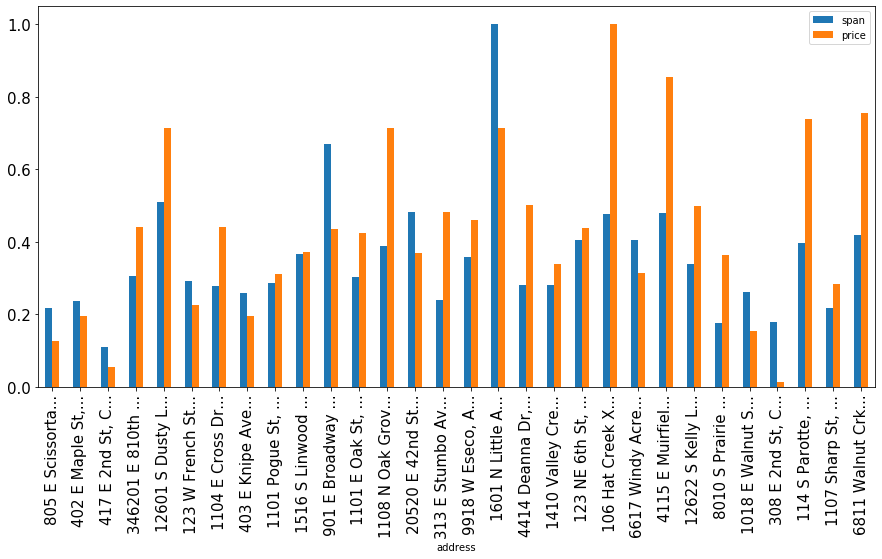

In [18]:
import matplotlib
import numpy as np
# избавимся от колонок с неполной информацией
df = df.replace(to_replace='None', value=np.nan).dropna()
low_lim = 20
high_lim = 50

df_num = pd.concat([df["span"], df["price"]], axis=1)
df_num = df_num.set_index(df["address"])
# Зададим пределы показываемых элементов и нормируем значения
df_num = df_num.astype('float64')[low_lim:high_lim]
df_num["span"] /= df_num["span"].max()
df_num["price"] /= df_num["price"].max()
ax = df_num.plot.bar(rot=90, figsize=(15,7), fontsize=15)